### 回顾
上一节课我们讲了：
- 手撸UNet网络结构

这节课我们讲：
- 迁移学习
    - Resnet论文概述
    - 将Resnet作为encoder替换U-Net原始结构

In [62]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision

from PIL import Image

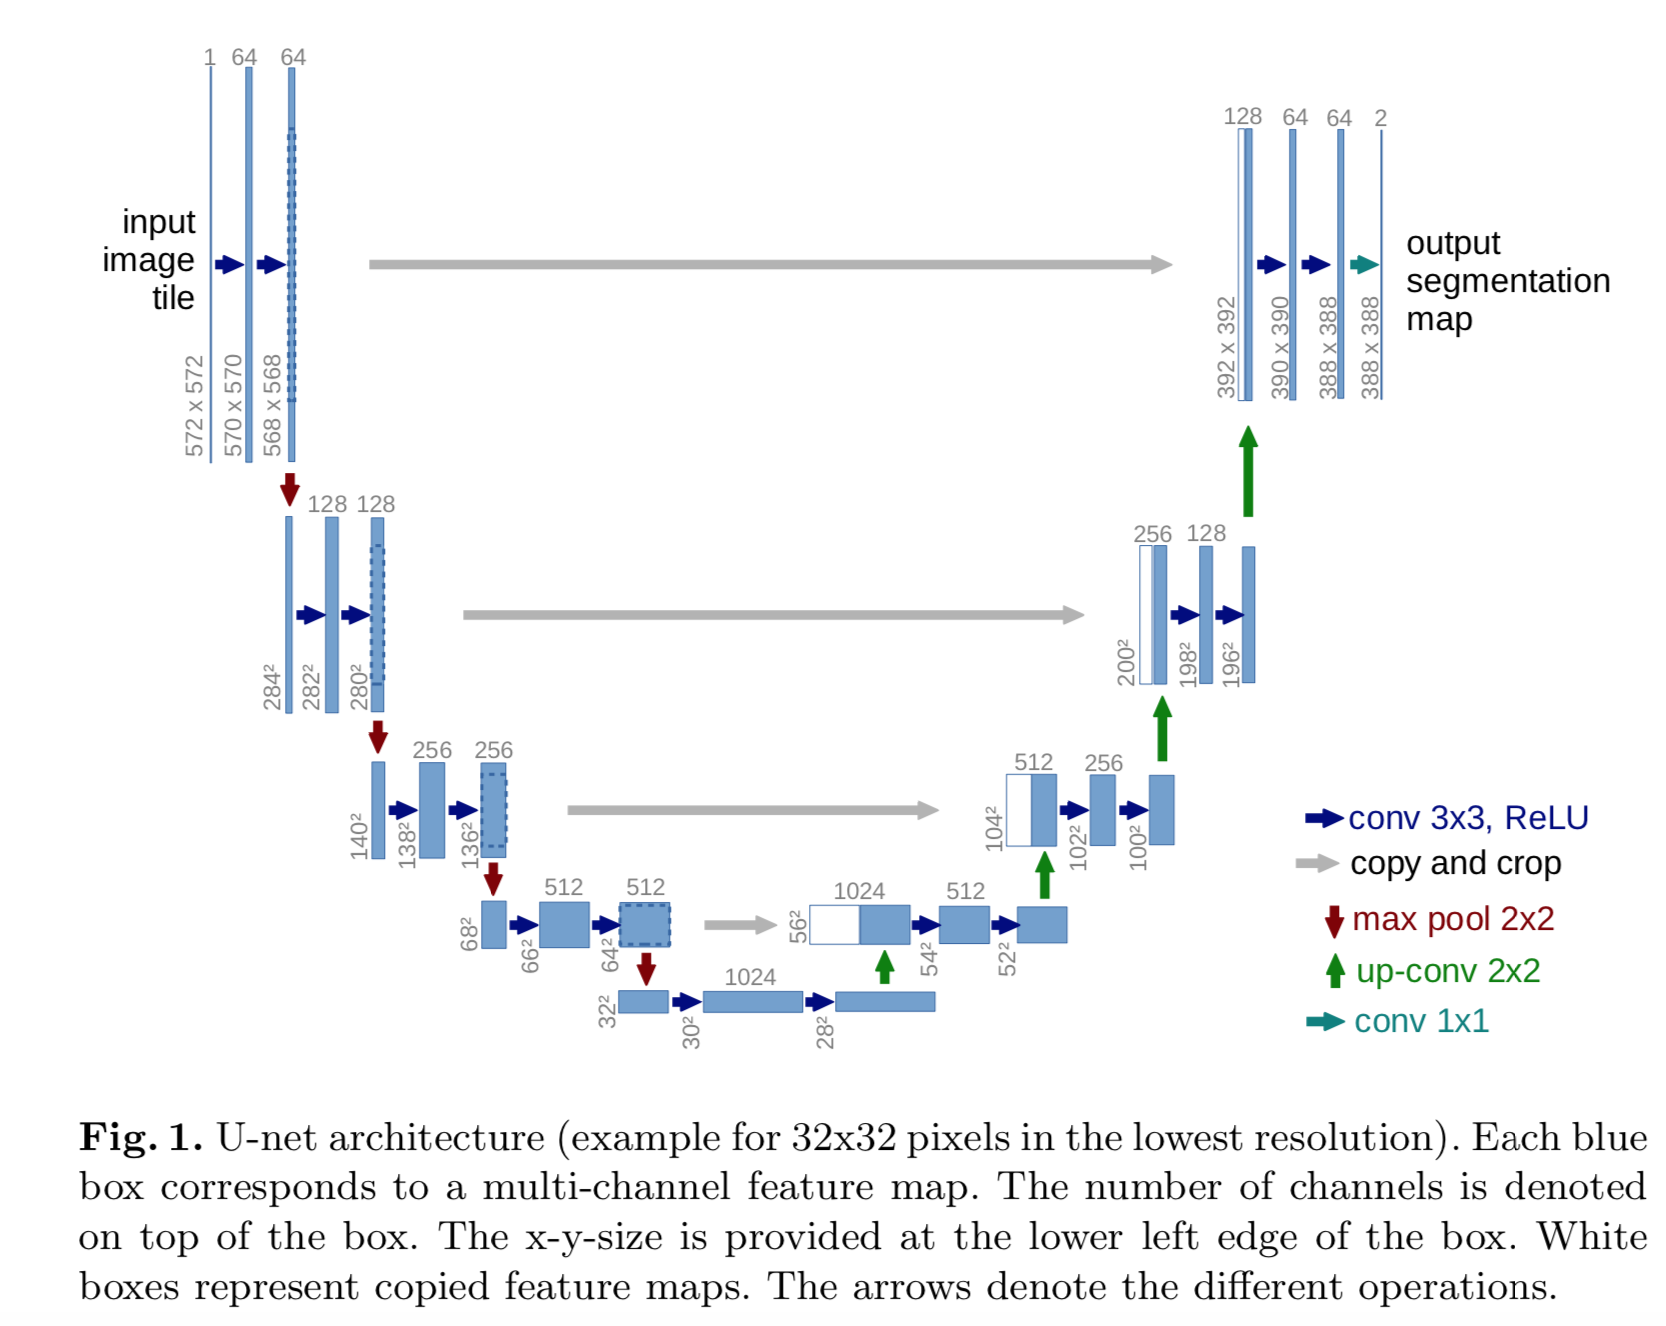

In [3]:
Image.open('network visualize.png')

### 迁移学习动机
下采样（contracting path）作用
- 学习图像特征图（feature maps）

所有的图像任务（分类、检测、分割）共同点
- 下采样——学习特征层

U-Net改进方向之一出发点
- U-Net提出时间较早，当时还没有例如resnet等网络结构和大规模预训练权重可用
- U-Net下采样的设计与诸多（如今）成熟的网络结构异曲同工
    - 特征图每一层降低尺寸/2
    - 特征图每一层channels数翻倍x2
- 成熟的网络结构、ImageNet预训练权重可以用来finetuning我们的U-Net，从而起到优化U-Net网络的效果

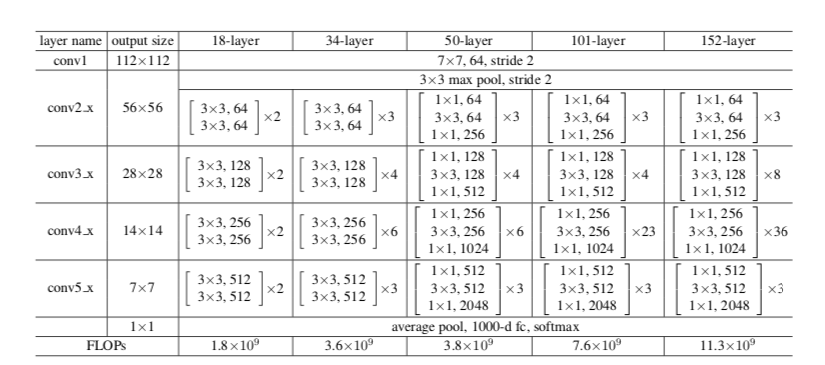

In [5]:
Image.open('resnet2.png')

### Resnet理论

重点：
1. 动机
    - 深度网络的训练非常困难（Fig 1）
    - 网络的深度正是很多视觉任务的关键点
2. Resnet提出（Residual Learning）
    - 优化的是什么？假定我们有一个很深的神经网络，它可以拟合任何复杂的目标函数H，那么它等价于可以拟合任何目标函数H-x
        - 函数复杂度上没有变化
        - 优化的函数变了，拟合参数的结果也变了
    - 优化H+x改变了什么？作用是什么？假如增加一层网络，参数更新趋向于不改变数据的映射（前一层到后一层的映射），那么参数的学习结果可以更倾向于保留H-x，即恒等映射
    - 虽然优化H或H-x的目的是相同的，但是“the ease of learning might be different”，言下之意，作者说Residual Learning优化比传统结构更容易

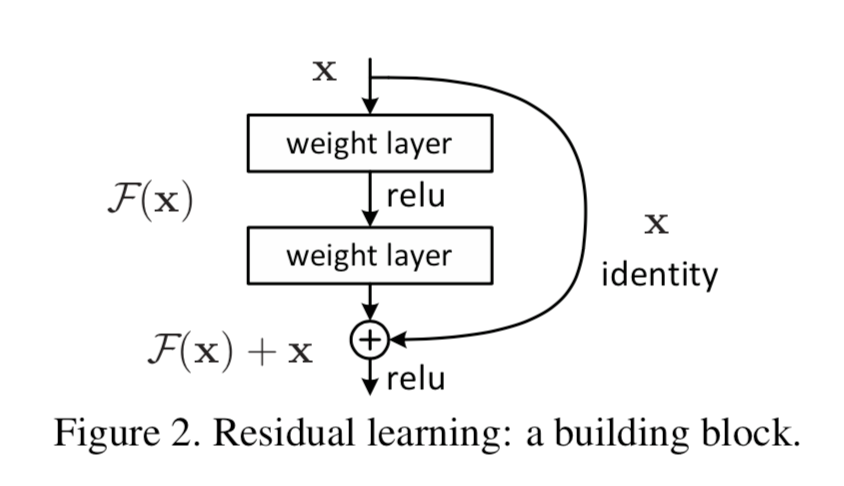

In [6]:
Image.open('resnet building block.png')

In [ ]:
class BasicBlock(nn.Module):
    """Residual Block
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### 整体架构

由4组Block构成，在前人设计的Plain Network基础上，修改成Residual Block，并满足两点设计原则：
- 同一Block内部，特征图尺寸不变，channel数维持不变
- 两组Block之间，特征图尺寸减半，channel数翻倍

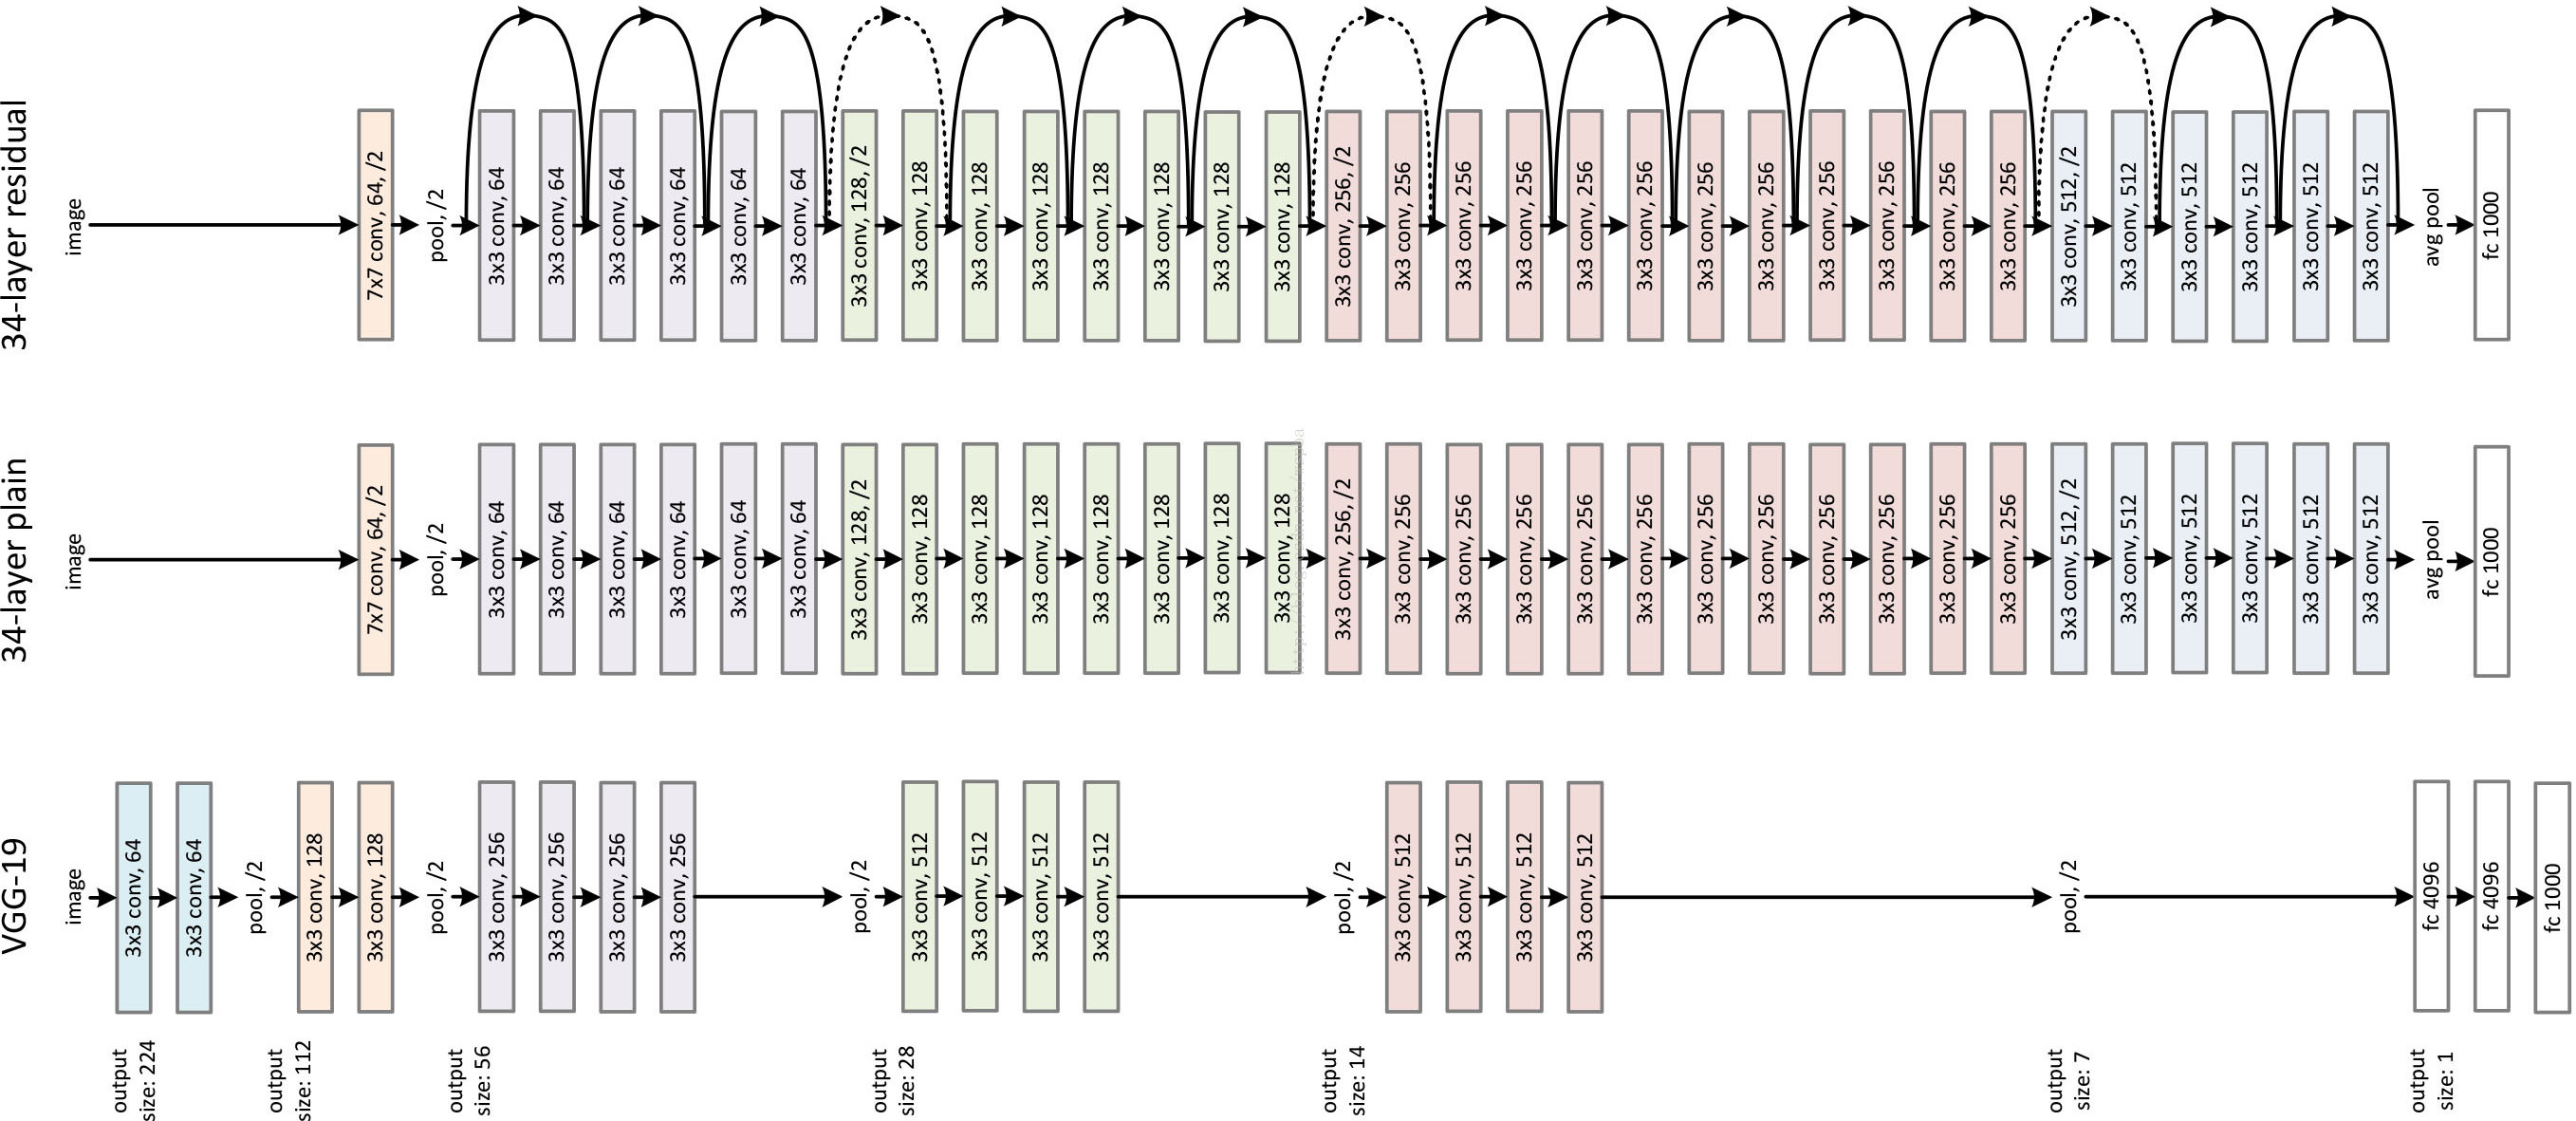

In [17]:
Image.open('resnet.jpeg')

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        ##================================================================================
        #._make_layer构造每一个子模块
        #block是Resnet的一个最小的Identity Block
        #layers指block重复次数，图中Resnet34是[3, 4, 6, 3]
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        ##================================================================================
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        #=====================
        #下采样过程，学习特征图feature maps
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #=====================

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

### U-Net下采样过程改造，移植Resnet

In [126]:
net = torchvision.models.resnet34(pretrained=False)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [127]:
# def contracting_block(in_channels, out_channels):
#     block = torch.nn.Sequential(
#         nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=out_channels),
#         nn.ReLU(),
#         nn.BatchNorm2d(out_channels),
#         nn.Conv2d(kernel_size=(3,3), in_channels=out_channels, out_channels=out_channels),
#         nn.ReLU(),
#         nn.BatchNorm2d(out_channels)
#     )
#     return block

class expansive_block(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(expansive_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=mid_channels, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(kernel_size=(3,3), in_channels=mid_channels, out_channels=out_channels, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, d, e=None):
        #====================================
        #修改二
        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True)
        #concat
        if e is not None:
            cat = torch.cat([e, d], dim=1)
            out = self.block(cat)
        else:
            out = self.block(d)
        return out
        #====================================

def final_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=out_channels, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
    )
    return block

class ResnetUNet(nn.Module):
    
    def __init__(self, in_channel, out_channel, pretrained=False):
        super(ResnetUNet, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=pretrained)
        
        self.layer0 = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            #self.resnet.maxpool
        )
        
        #====================================
        #修改一
        #Encode
        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4
        #====================================
        
        #Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(kernel_size=(3,3), in_channels=512, out_channels=1024, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(kernel_size=(3,3), in_channels=1024, out_channels=1024, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        
        #====================================
        #修改三
        # Decode
        self.conv_decode4 = expansive_block(1024+512, 512, 512)
        self.conv_decode3 = expansive_block(512+256, 256, 256)
        self.conv_decode2 = expansive_block(256+128, 128, 128)
        self.conv_decode1 = expansive_block(128+64, 64, 64)
        self.conv_decode0 = expansive_block(64, 32, 32)
        #====================================
        
        self.final_layer = final_block(32, out_channel)
    
    def forward(self, x):
        x = self.layer0(x);print('layer0:', x.size())
        
        # Encode
        encode_block1 = self.layer1(x);print('encode_block1:', encode_block1.size())
        encode_block2 = self.layer2(encode_block1);print('encode_block2:', encode_block2.size())
        encode_block3 = self.layer3(encode_block2);print('encode_block3:', encode_block3.size())
        encode_block4 = self.layer4(encode_block3);print('encode_block4:', encode_block4.size())

        # Bottleneck
        bottleneck = self.bottleneck(encode_block4);print('bottleneck:', bottleneck.size())
        
        # Decode
        decode_block4 = self.conv_decode4(bottleneck, encode_block4);print('decode_block4:', decode_block4.size())
        decode_block3 = self.conv_decode3(decode_block4, encode_block3);print('decode_block3:', decode_block3.size())
        decode_block2 = self.conv_decode2(decode_block3, encode_block2);print('decode_block2:', decode_block2.size())
        decode_block1 = self.conv_decode1(decode_block2, encode_block1);print('decode_block1:', decode_block1.size())
        decode_block0 = self.conv_decode0(decode_block1);print('decode_block0:', decode_block0.size())
        
        final_layer = self.final_layer(decode_block0);print('final_layer:', final_layer.size())
        return final_layer

In [128]:
image = torch.rand((1, 3, 512, 512))

In [129]:
unet = ResnetUNet(in_channel=3, out_channel=1, pretrained=True)#令pretrained=True使用ImageNet预训练权重

In [130]:
mask = unet(image)

layer0: torch.Size([1, 64, 256, 256])
encode_block1: torch.Size([1, 64, 256, 256])
encode_block2: torch.Size([1, 128, 128, 128])
encode_block3: torch.Size([1, 256, 64, 64])
encode_block4: torch.Size([1, 512, 32, 32])
bottleneck: torch.Size([1, 1024, 16, 16])
decode_block4: torch.Size([1, 512, 32, 32])
decode_block3: torch.Size([1, 256, 64, 64])
decode_block2: torch.Size([1, 128, 128, 128])
decode_block1: torch.Size([1, 64, 256, 256])
decode_block0: torch.Size([1, 32, 512, 512])
final_layer: torch.Size([1, 1, 512, 512])


### 练习


学习了用Resnet改造UNet，同样的思路，可以用各种预训练的网络结构改造UNet
- Resnet101
- EfficientNet
- ...

[代码](https://github.com/niudd/deepshare-unet-theory)